# SWE546_Final_Project
## Names: Fatih Aracı and Okan Menevşeoğlu
---
Final Project for data mining

As the final project, you will develop a method for recommendation.

Steps:

* Form groups of two or three. If you prefer to do so, you can also work alone.
* Analyze the public data set given in http://files.grouplens.org/datasets/movielens/ml-10m-README.html The goal is to develop a recommendation system, by predicting the ratings for unobserved user-movie pairs.

You need to submit a report, preferably as an jupyter notebook, that contains

* the description of the dataset along with snapshots of visualizations
* a mathematical description of the models that you have developed and any features that you have developed. There must be at least two different methods.
* the code for your simulations, should be runnable
* a description and discussion of the evaluation criteria,
* an evaluation of your system along with a comparion of the results by the methods you have proposed

Submit your report with all the material by 3rd June, 19:00 by a pull request.

Optional but recommended:
* Present your results at our final meeting in 3rd June, Friday. 19:00

You can also choose another data set, such as data from a kaggle competition such as https://www.kaggle.com/c/expedia-hotel-recommendations

---

# The Competition: Facebook Check-Ins for a Virtual World
## Identify the correct place for check ins

Ever wonder what it's like to work at Facebook? Facebook and Kaggle are launching a machine learning engineering competition for 2016. Trail blaze your way to the top of the leaderboard to earn an opportunity at interviewing for one of the 10+ open roles as a software engineer, working on world class machine learning problems.
<img style="border: 1px solid black" src="https://kaggle2.blob.core.windows.net/competitions/kaggle/5186/media/FB5_banner.png" width="640" height="200">
The goal of this competition is to predict which place a person would like to check in to. For the purposes of this competition, Facebook created an artificial world consisting of more than 100,000 places located in a 10 km by 10 km square. For a given set of coordinates, your task is to return a ranked list of the most likely places. Data was fabricated to resemble location signals coming from mobile devices, giving you a flavor of what it takes to work with real data complicated by inaccurate and noisy values. Inconsistent and erroneous location data can disrupt experience for services like Facebook Check In.

We highly encourage competitors to be active on Kaggle Scripts. Your work there will be thoughtfully included in the decision making process.

---

## Refining The Data
Facebook designed a virtual world with the size of 10 square kilometers. There are 29 million check-ins made in this area with a huge number of places. Since Facebook wants create a competitive challange, the data is not explained in detail. For example there is a timestamp like epoch however it is on much smaller scale (we found that it is in minutes).

Here are information from the data:
* There are 29.118.021 check-ins in the data
* There are 1575 place ids in total
* r_id: the unique check-in ids
* x: the x coordinate
* y: the y coordinate
* accuracy: the check-in error; distance in meters from the location
* time: in minutes
* place_id: a unique value for each different location

Since the data is huge, we first tried to refine it by using Python. However, it took too much time even with an 8-core CPU. So, we thought that a database (SQL) might work faster. We used a third party tool to convert the csv into sqlite format. Then, by using a database viewer, we changed the data types from text to integer and real values in order to get faster results.

#### Facebook Data Table (SQLite):
<img style="border: 2px solid green" src="https://dl.dropboxusercontent.com/u/3272208/Database.png">

After this, we focused on 3 points to refine the data;

- A smaller space: 100 km sq. is too big to use data-mining methods in our computers so, we choosed a smaller square (4 km sq.).

- Limit error margin (accuracy): The data has also accuracy value. As we checked online, most of the modern GPS devices has the error margin up to 10 meters. So, we decided to analyze the ones that have an accuracy smaller than 10 meters.

- Popular places: The locations which have more than 100 check-ins.
<img style="border: 2px solid green" src="http://s19.postimg.org/quyp3pqj7/sql4to6.png">

## 1) Reading the Data

In [18]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.pyplot as pyplot
import scipy as sc
from mpl_toolkits.mplot3d import axes3d
from sklearn import cluster, datasets
from sklearn.decomposition import PCA

%matplotlib inline

# Read facebook data
facebook = pd.read_csv(u'data/RefinedFacebookData(4to6).csv',sep=',')

# Print a sample of size 5
facebook.sample(5)

,r_id,x,y,accuracy,time,place_id
7028,7852621,5.7885,5.4013,9,612471,1196489948
4336,4779277,5.0918,4.6359,8,66017,6010979584
14987,16668062,4.5796,5.1769,5,596568,8817926191
17110,19075893,4.4314,4.9183,9,20267,5255984823
23584,26220838,4.1174,4.3573,10,523393,5360769747


## 2) View The Data on a 2D Scatter Plot

In [19]:
# Create x, y, accuracy and time matrices
x = np.vstack(facebook.x)
y = np.vstack(facebook.y)
accuracy = np.vstack(facebook.accuracy)
time = np.vstack(facebook.time)

# Create facebook matrix for x and y values
facebook_matrix = np.hstack([x,y])

# Print for show
facebook_matrix

array([[ 5.1662,  4.3649],
       [ 5.2908,  5.3881],
       [ 4.5803,  4.8879],
       ..., 
       [ 4.9196,  4.6754],
       [ 4.7601,  4.5154],
       [ 5.1208,  5.0962]])

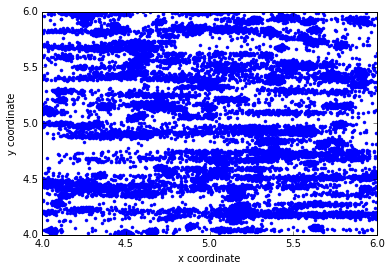

In [20]:
# Print the data on a 2D scatter plot for x and y coordinates
plt.plot(x, y, 'b.')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.show()

## 3) View The Data on a 3D Scatter Plot Based on Time Constraint

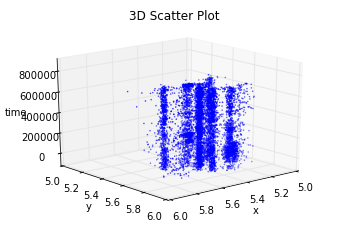

In [21]:
# Print the data on a 3D scatter plot for x, y, and time constraints
thedata = np.genfromtxt('data/RefinedFacebookData.csv',   # file name
                        delimiter=',',                    # column delimiter
                        dtype='float',                    # data type
                        usecols = (1, 2, 4),              # use 3 columns only
                        names=['x','y','time']            # column names
                       )
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.set_title('3D Scatter Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('time')

ax.set_xlim(5, 6)
ax.set_ylim(5, 6)

ax.view_init(elev=20, azim=50)              # elevation and angle
ax.dist=11                                  # distance

ax.scatter(
           thedata['x'], thedata['y'], thedata['time'],  # data
           color='blue',                            # marker colour
           marker='.',                                # marker shape
           s=1                                       # marker size
           )
plt.show()

## 4) K-Means Clustering for 4 sq. km

In [22]:
# K-Means Clustering algorithm
k_means = cluster.KMeans(n_clusters = 25)
k_means.fit(facebook_matrix)
labels = k_means.labels_
centroids = k_means.cluster_centers_

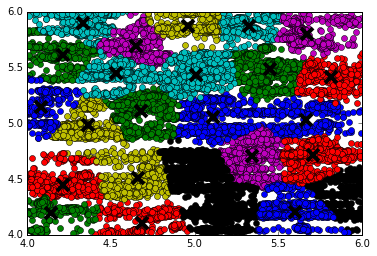

array([[ 5.66328871,  5.03121003],
       [ 4.21175822,  5.60779476],
       [ 4.68818945,  4.10365494],
       [ 5.32600927,  5.872578  ],
       [ 5.34283708,  4.70233872],
       [ 4.36610368,  4.98165845],
       [ 5.89512091,  4.38682832],
       [ 5.10858188,  5.05670233],
       [ 5.45062522,  5.48614048],
       [ 4.21190875,  4.4489224 ],
       [ 4.33346126,  5.89940263],
       [ 4.65008253,  5.69341168],
       [ 4.65949377,  4.50606139],
       [ 5.17345714,  4.23230306],
       [ 5.59905916,  4.20084439],
       [ 4.68173803,  5.11135117],
       [ 5.81484867,  5.41471955],
       [ 5.01076143,  5.43092607],
       [ 5.67435846,  5.80059765],
       [ 4.95971355,  5.8695374 ],
       [ 5.00122612,  4.57915284],
       [ 4.08171049,  5.14381439],
       [ 4.14489551,  4.19165393],
       [ 5.70561529,  4.71322319],
       [ 4.53279239,  5.44810243]])

In [23]:
# Print Clusters
for i in range(25):
    # select only data observations with cluster label == i
    ds = facebook_matrix[np.where(labels==i)]
    # plot the data observations
    pyplot.plot(ds[:,0],ds[:,1],'o')
    # plot the centroids
    lines = pyplot.plot(centroids[i,0],centroids[i,1],'kx')
    # make the centroid x's bigger
    pyplot.setp(lines,ms=12.0)
    pyplot.setp(lines,mew=4.0)
pyplot.show()

centroids

## 5) K-Means Clustering for 5.3 to 6 for x and 5.3 to 6 for y

A more refined data based on observations:
<img style="border: 2px solid green" src="http://s19.postimg.org/al8j0tfv7/sql5_3to6.png">

In [24]:
# Read new data
facebook_new = pd.read_csv(u'data/RefinedFacebookData(5-3to6).csv',sep=',')
# Create x, y, accuracy and time matrices
x_new = np.vstack(facebook_new.x)
y_new = np.vstack(facebook_new.y)
accuracy_new = np.vstack(facebook_new.accuracy)
time_new = np.vstack(facebook_new.time)
place_id_new = np.vstack(facebook_new.place_id)

# Create facebook matrix for x and y values
facebook_matrix_new = np.hstack([x_new,y_new])

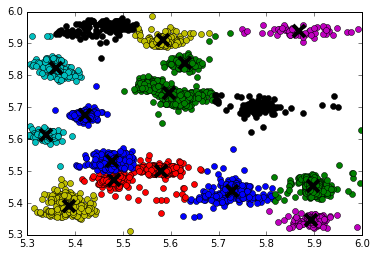

array([[ 5.72787016,  5.43604922],
       [ 5.59563264,  5.74520532],
       [ 5.48099123,  5.47050936],
       [ 5.36033244,  5.82396489],
       [ 5.89372411,  5.34513393],
       [ 5.58444557,  5.91183671],
       [ 5.78063832,  5.70037485],
       [ 5.42039313,  5.67595954],
       [ 5.89820939,  5.4515509 ],
       [ 5.57928779,  5.50119014],
       [ 5.33829732,  5.61148571],
       [ 5.86927679,  5.93837143],
       [ 5.38694109,  5.39162909],
       [ 5.46025245,  5.94974615],
       [ 5.47655568,  5.53190966],
       [ 5.62914384,  5.83849315]])

In [25]:
# K-Means Clustering based on 16 clusters
n_clusters = 16
k_means = cluster.KMeans(n_clusters)
k_means.fit(facebook_matrix_new)
labels = k_means.labels_
centroids = k_means.cluster_centers_

# Print Clusters
for i in range(n_clusters):
    # select only data observations with cluster label == i
    ds = facebook_matrix_new[np.where(labels==i)]
    # plot the data observations
    pyplot.plot(ds[:,0],ds[:,1],'o')
    # plot the centroids
    lines = pyplot.plot(centroids[i,0],centroids[i,1],'kx')
    # make the centroid x's bigger
    pyplot.setp(lines,ms=12.0)
    pyplot.setp(lines,mew=4.0)
pyplot.show()

centroids

## 6) Find the closest cluster for a given x, y coordinates

In [26]:
# New (any) X and Y values (x between 5.3-6 and y between 5.6-6)
new_x = 5.6178
new_y = 5.8212
smallest_distance = float('inf')
for i in range(len(centroids)):
    distance = np.sqrt(np.square(new_x - centroids[i,0]) + np.square(new_y - centroids[i,1]))
    if(distance < smallest_distance):
        smallest_distance = distance
        smallest_distance_index = i
print("The new point is closest to the cluster", smallest_distance_index, "with the distance of", smallest_distance)
print("Cluster", smallest_distance_index, "center point:", centroids[smallest_distance_index])

The new point is closest to the cluster 15 with the distance of 0.0206817713725
Cluster 15 center point: [ 5.62914384  5.83849315]


## 7) Find the closest 10 points to the center for a given cluster

In [27]:
# New matrix with place information
facebook_matrix_with_places = np.hstack([x_new,y_new,place_id_new])

# Find the closest 10 points to the center for the given cluster
def closestTen(cluster_number):
    closest_array = {}
    for k in range(len(facebook_matrix_with_places)):
        distance = np.sqrt(np.square(facebook_matrix_with_places[k,0] - centroids[cluster_number,0]) + np.square(facebook_matrix_with_places[k,1] - centroids[cluster_number,1]))
        closest_array[distance] = facebook_matrix_with_places[k,2]
    return closest_array

In [28]:
import collections
od = collections.OrderedDict(sorted(closestTen(smallest_distance_index).items()))
print("Distance", "\t  ", "Place Id")
print("--------", "\t  ", "--------")
i=1
for k, v in od.items():
    print(i, "-)", k*1000, int(round(v)))
    if(i>=10):
        break
    i = i+1

Distance 	   Place Id
-------- 	   --------
1 -) 0.61947501669 5648621542
2 -) 2.03636023211 5648621542
3 -) 2.49048517755 5648621542
4 -) 2.67229237857 5648621542
5 -) 2.91184096225 5648621542
6 -) 3.16974934973 5648621542
7 -) 4.180865904 5648621542
8 -) 4.2503725842 5648621542
9 -) 4.72285857632 5648621542
10 -) 5.05660249064 5648621542
